# Forecasting taxi orders

The company "Cool Taxi" has collected historical data on taxi orders at airports.To attract more drivers during the peak load, you need to predict the number of taxi orders for the next hour.Build a model for such a prediction.

The value of the metric *RMSE* in the test sample should be no more than 48.

You need:

1. Download the data and make their reinforcement for one hour.
2. To analyze the data.
3. Teach different models with various hyperparameters.Make a test sample with a size of 10% of the source data.
4. Check the data on the test sample and draw conclusions.


Data lie in the file `taxi.csv`.The number of orders is in the `num_orders` column (from the English. *Number of Orders *,«number of orders»).

## Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [2]:
try:
    path_df = os.path.join('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    df = pd.read_csv(path_df)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)
df = df.resample('1H').sum()

## Analysis

Take a look at the general information on the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


4416 records from March 1 to August 31, 2018, no passes

Let's take a look at descriptive statistics

In [4]:
df.describe()

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


- the maximum number of challenges per hour was 462 values,
- minimum 0
- Standard deviation 45 calls

Let's look at the temporary series

<Axes: title={'center': 'Time series by orders'}, xlabel='datetime'>

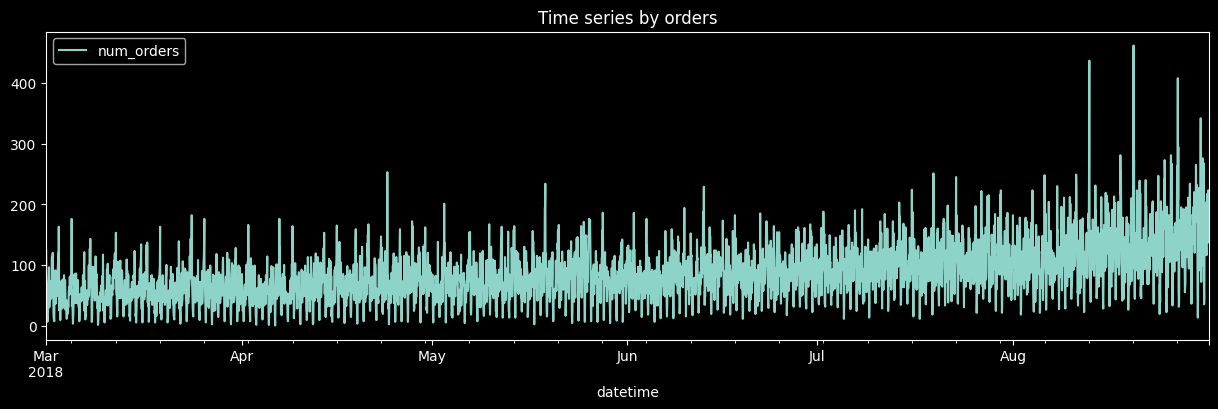

In [5]:
df.plot(figsize=(15,4), title='Time series by orders')

It looks too noisy, let's look at the sliding average per day

<Axes: title={'center': 'Time series by orders (moving average per day)'}, xlabel='datetime'>

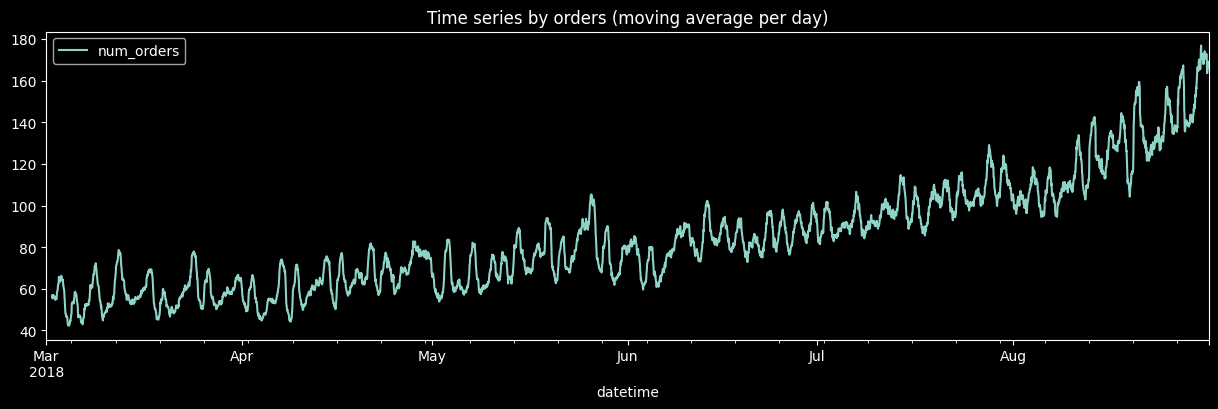

In [6]:
df.rolling(24).mean().plot(figsize=(15,4), title='Time series by orders (moving average per day)')

Let's see for a month

<Axes: title={'center': 'Time series by orders (moving average per Month)'}, xlabel='datetime'>

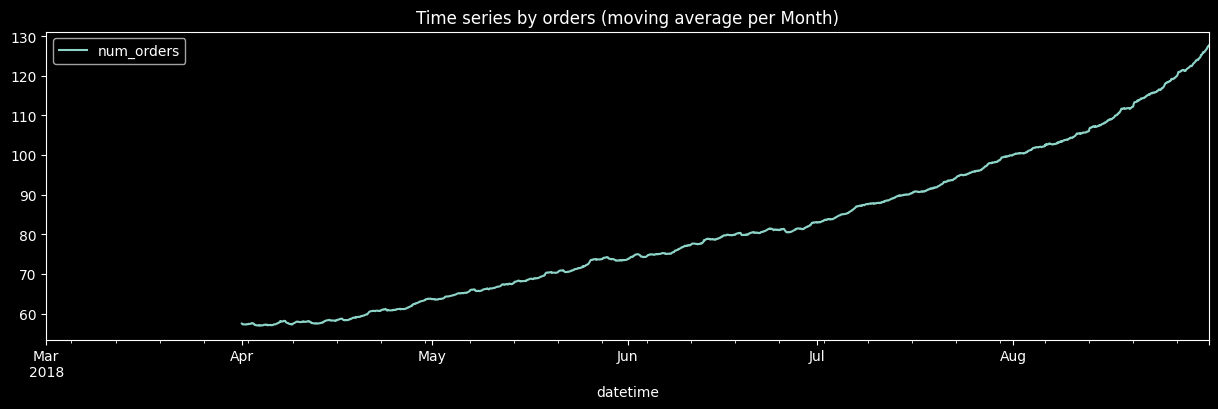

In [7]:
df.rolling(24*31).mean().plot(figsize=(15,4), title='Time series by orders (moving average per Month)')

Take a look at the decomposition of trends and seasonality

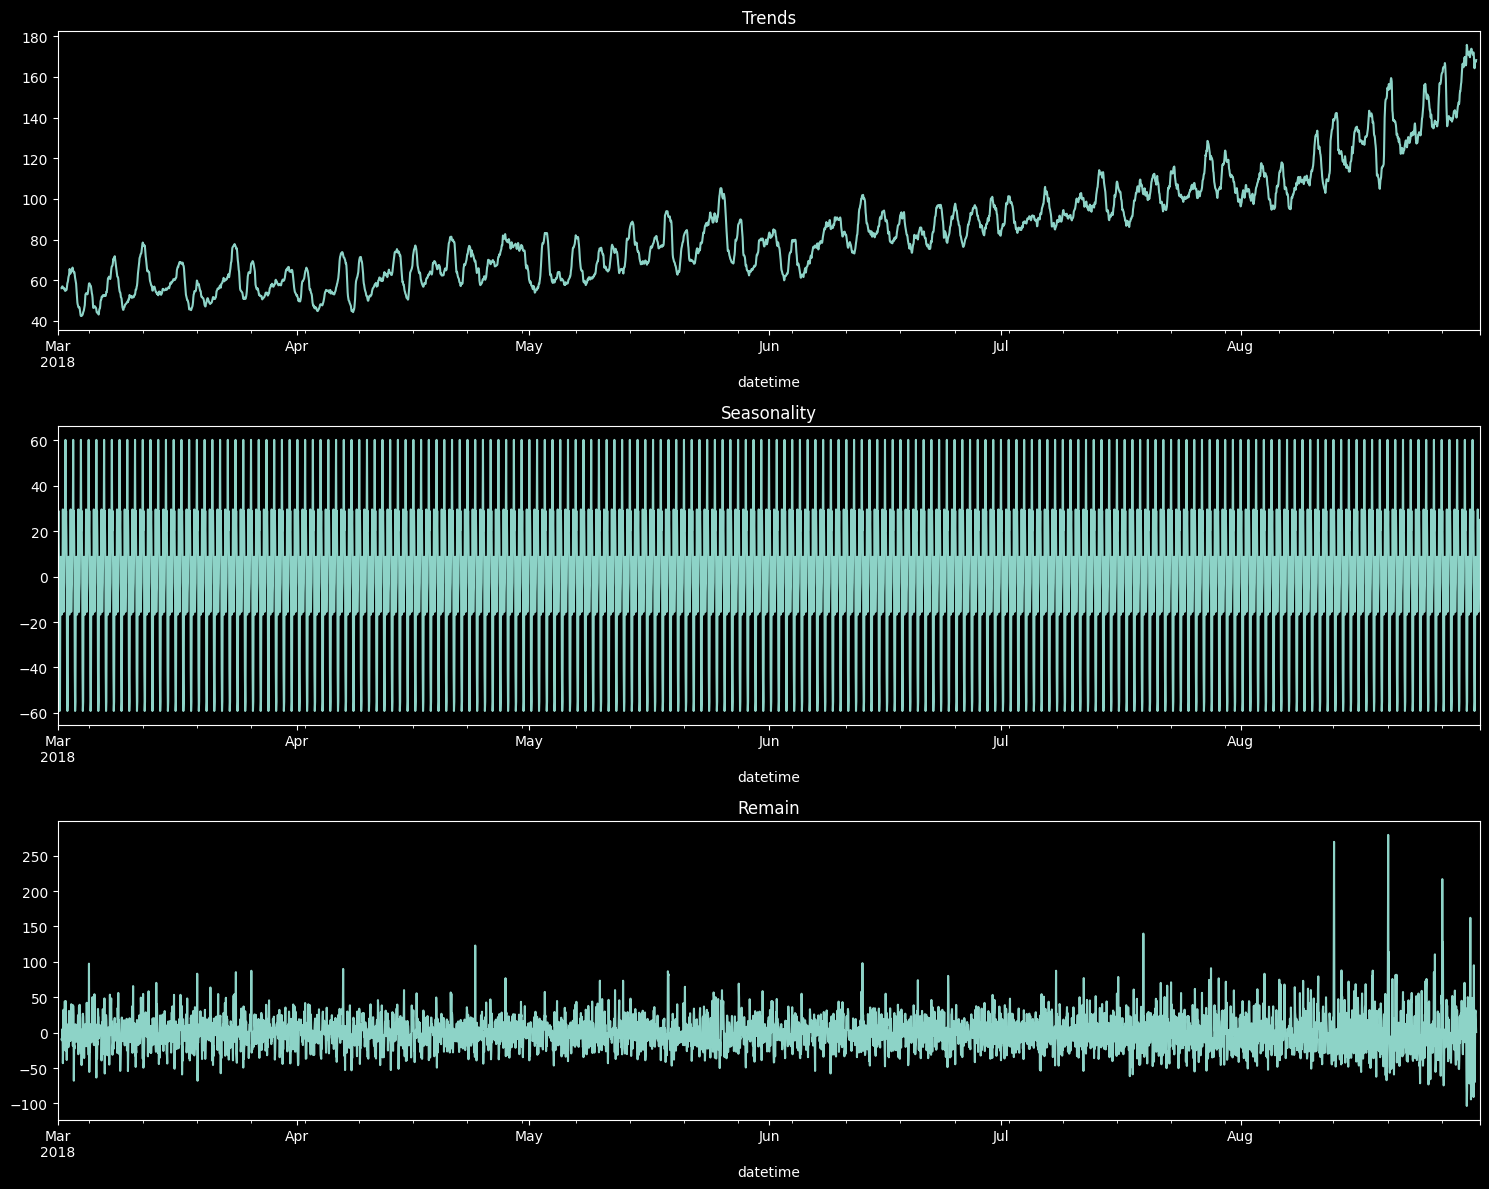

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trends')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Remain')
plt.tight_layout()

We are close to the scale

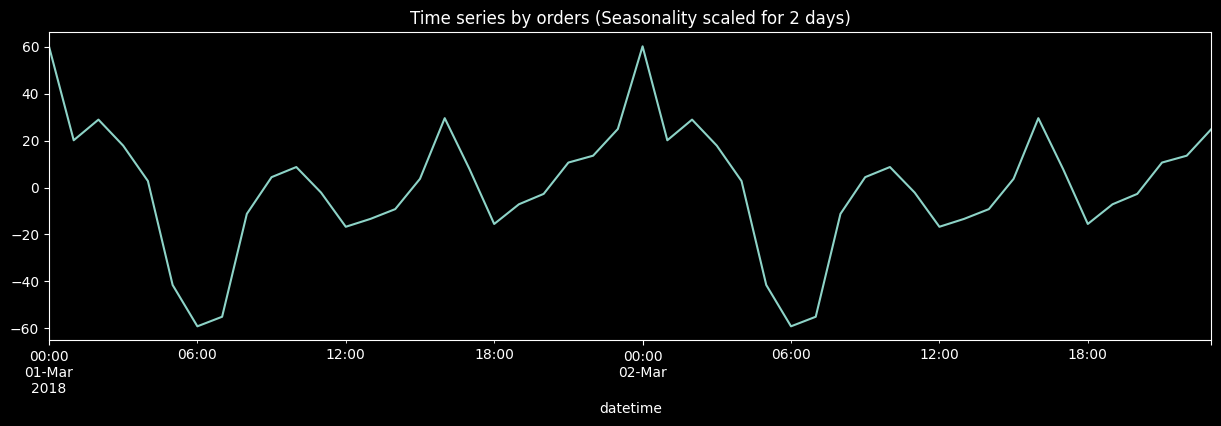

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15, 4), title='Time series by orders (Seasonality scaled for 2 days)');

- the increasing trend with acceleration smoothly increasing exposure in the entire observed period is visible
- The dishwasher of the stationary row is visible, by 12 in the morning the orders increase, by 7 in the morning they fall to a minimum, still small peaks at about 10:00 and 17:00
- the dispersion of the residues increases over time, the noise at the end of the observed period becomes greater

## Education

We will write a function to create signs

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Let's look at the auto -correction for the significance of the lags

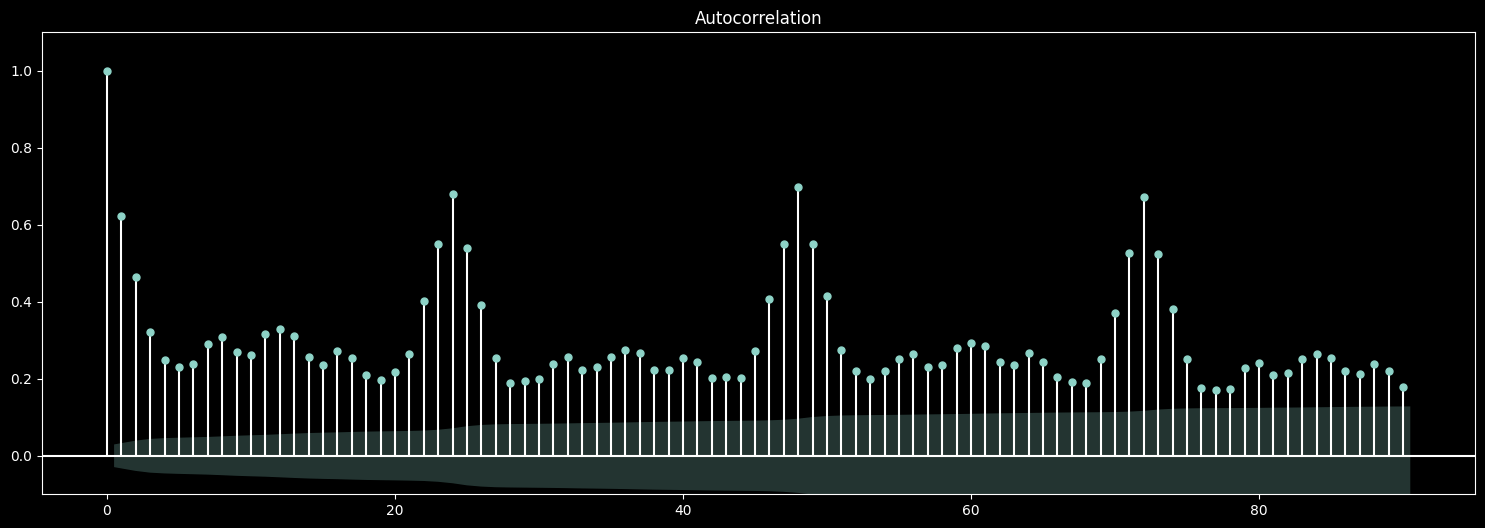

In [11]:
fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Create signs with lags in a week and sliding per day

In [12]:
make_features(df, 168, 24)

## Split dataset for 2 samples

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Create an object of crossvaling `TimeserIssplit`

In [14]:
tscv = TimeSeriesSplit(n_splits=10)

## decisiontreegressor

We will search for hyperparameters for `decisiontreegressor` using` Gridsearchcv`

In [15]:
dt_params = {'max_depth':[x for x in range(2, 21)]}
dt_model = DecisionTreeRegressor(random_state=1337) 

dt_gsearch = GridSearchCV(estimator=dt_model, cv=tscv, param_grid=dt_params, scoring='neg_mean_squared_error', error_score='raise')
dt_gsearch.fit(X_train, y_train)

dt_rmse = round(abs(dt_gsearch.best_score_)**0.5, 4)

print('Best results of DecisionTreeRegressor model on cross-validation')
print('RMSE =', dt_rmse)
print()
print('with parameters:')
print(dt_gsearch.best_params_)

Best results of DecisionTreeRegressor model on cross-validation
RMSE = 24.179

with parameters:
{'max_depth': 4}


## Catboost

We will search for hyperparameters for `CatBoost` using `GridSearchCV`

In [16]:
cb_params = {'learning_rate':[0.01,0.02,0.03,0.06,0.1,0.2,0.3]}
cb_model = CatBoostRegressor(verbose=False,
                             random_state=1337)

cb_gsearch = GridSearchCV(estimator=cb_model, cv=tscv, param_grid=cb_params, scoring='neg_mean_squared_error')
cb_gsearch.fit(X_train, y_train)

cb_rmse = round(abs(cb_gsearch.best_score_)**0.5, 4)

print('Best results of CatBoostRegressor model on cross-validation')
print('RMSE =', cb_rmse)
print()
print('with parameters:')
print(cb_gsearch.best_params_)

Best results of CatBoostRegressor model on cross-validation
RMSE = 20.4555

with parameters:
{'learning_rate': 0.01}


In [17]:
comparison = pd.DataFrame({'Model': ['DecisionTreeRegressor','CatBoostRegressor'],
                           'RMSE':[dt_rmse, cb_rmse]})
comparison

,Model,RMSE
0,DecisionTreeRegressor,24.18
1,CatBoostRegressor,20.46


Model `CatBoostregressor` on the ross of validation showed the result better

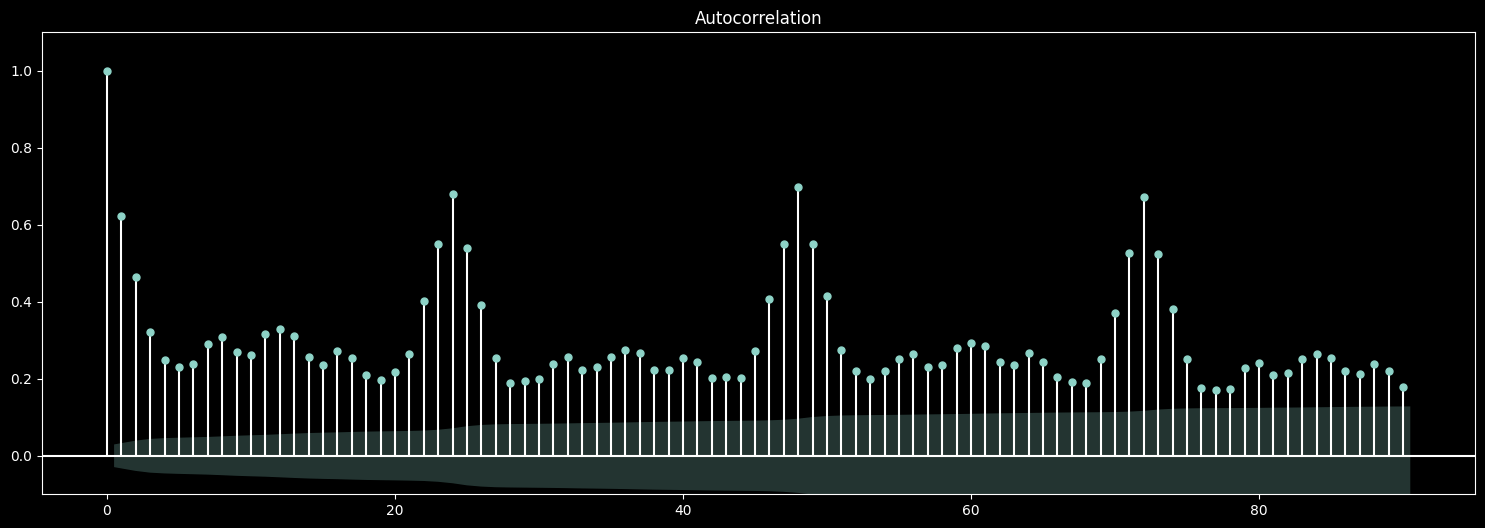

In [18]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



## Testing

In [19]:
model = CatBoostRegressor(verbose=False,
                          random_state=1337,
                          learning_rate=0.01
                          )
model.fit(X_train, y_train)

In [20]:
predict_test = model.predict(X_test)
rmse = mean_squared_error(y_test, predict_test)**0.5
print("RMSE on test: ", rmse)

RMSE on test:  39.168062874918384


## We will check the model for adequacy

To check, let's take the prediction based on the previous measurement

In [21]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

dummy_rmse = mean_squared_error(y_test, pred_previous)**0.5
print('Dummy RMSE: ', dummy_rmse)

Dummy RMSE:  53.36807644753937


Conclusion:
- the data is imported and analyzed
- The model of gradient boosting is trained
- rmse> 48 received
- Verification for adequacy the model passes